In [1]:
#make it interactive
%matplotlib notebook


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

plt.ion()

#function for creating spatial index and using it to perform intersection 
def intersect_sindex(source, intersecting):
    source_sindex = source.sindex
    possible_matches_index = []

    for other in intersecting.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

    # Get unique candidates
    unique = list(set(possible_matches_index))
    possible_matches = source.iloc[unique]

    # Conduct the intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting.unary_union)]
    return result

C:\Users\DEARDEN\Anaconda3\envs\egm722\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [7]:
#Load data and transform to global UTM
pa = gpd.read_file('data_files/WDPA_DRC_2021_proj.shp')
pa = pa.to_crs('epsg:3395')
mines = gpd.read_file('data_files/osm_rd_congo_infrastructures_mining_fabrication.geojson')
mines = mines.to_crs('epsg:3395')
#Ensure that CRS's are the same
print(mines.crs)
print (pa.crs)


#Extract point features from mining dataset 
mines_points = mines.loc[mines['geomtype']=="points"]

#Save selection GeoJSON to SHP and load data
mines_points.to_file("data_files/osm_congo_mining_points.shp")
mines_shp = gpd.read_file("data_files/osm_congo_mining_points.shp")

epsg:3395
epsg:3395


<ipython-input-7-0cbd4ab310a5>:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  mines_points.to_file("data_files/osm_congo_mining_points.shp")


<IPython.core.display.Javascript object>


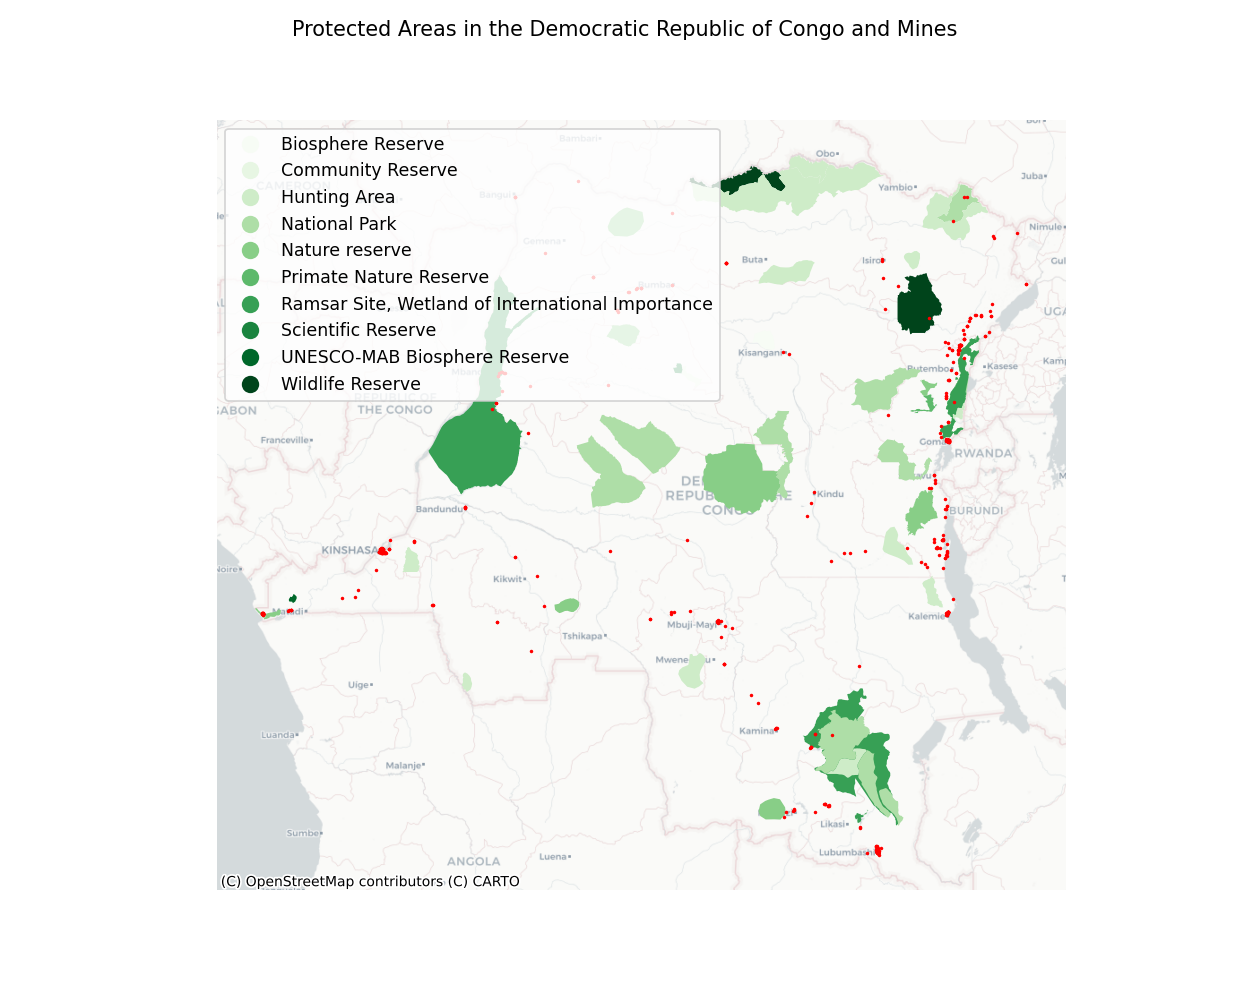

In [13]:
# test plot 
pa_map_test, ax = plt.subplots(1, figsize=(10,8))
ax = pa.plot("DESIG_ENG", legend = True, ax=ax, cmap="Greens")
mines_shp.plot(ax=ax, color="red", markersize=1, legend = True)
pa_map_test.suptitle('Protected Areas in the Democratic Republic of Congo and Mines')
ax.set_axis_off()
plt.show()

Use spatial index function to perform intersect and count intersections 

<IPython.core.display.Javascript object>


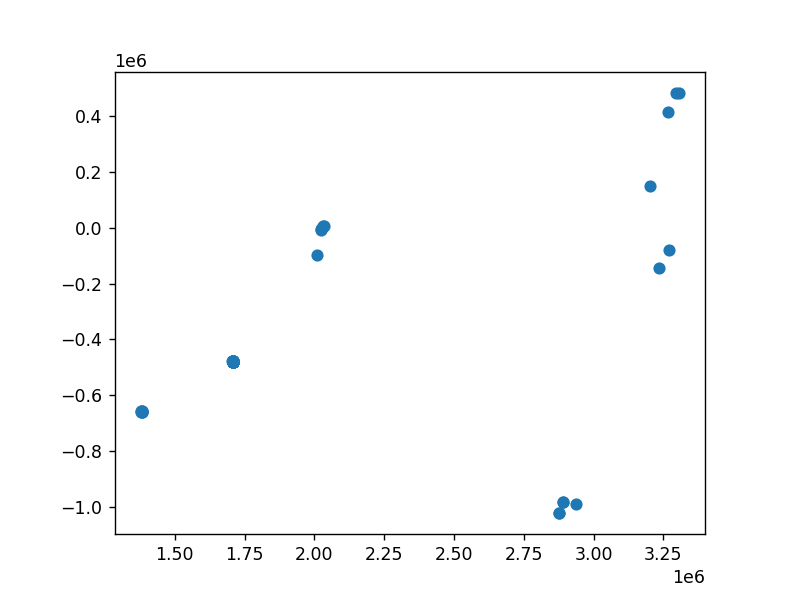

In [14]:
#Intersect 
pa_mine_intersect = intersect_sindex(source=mines_shp, intersecting=pa)
pa_mine_intersect.plot()
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Create and save first map

<IPython.core.display.Javascript object>


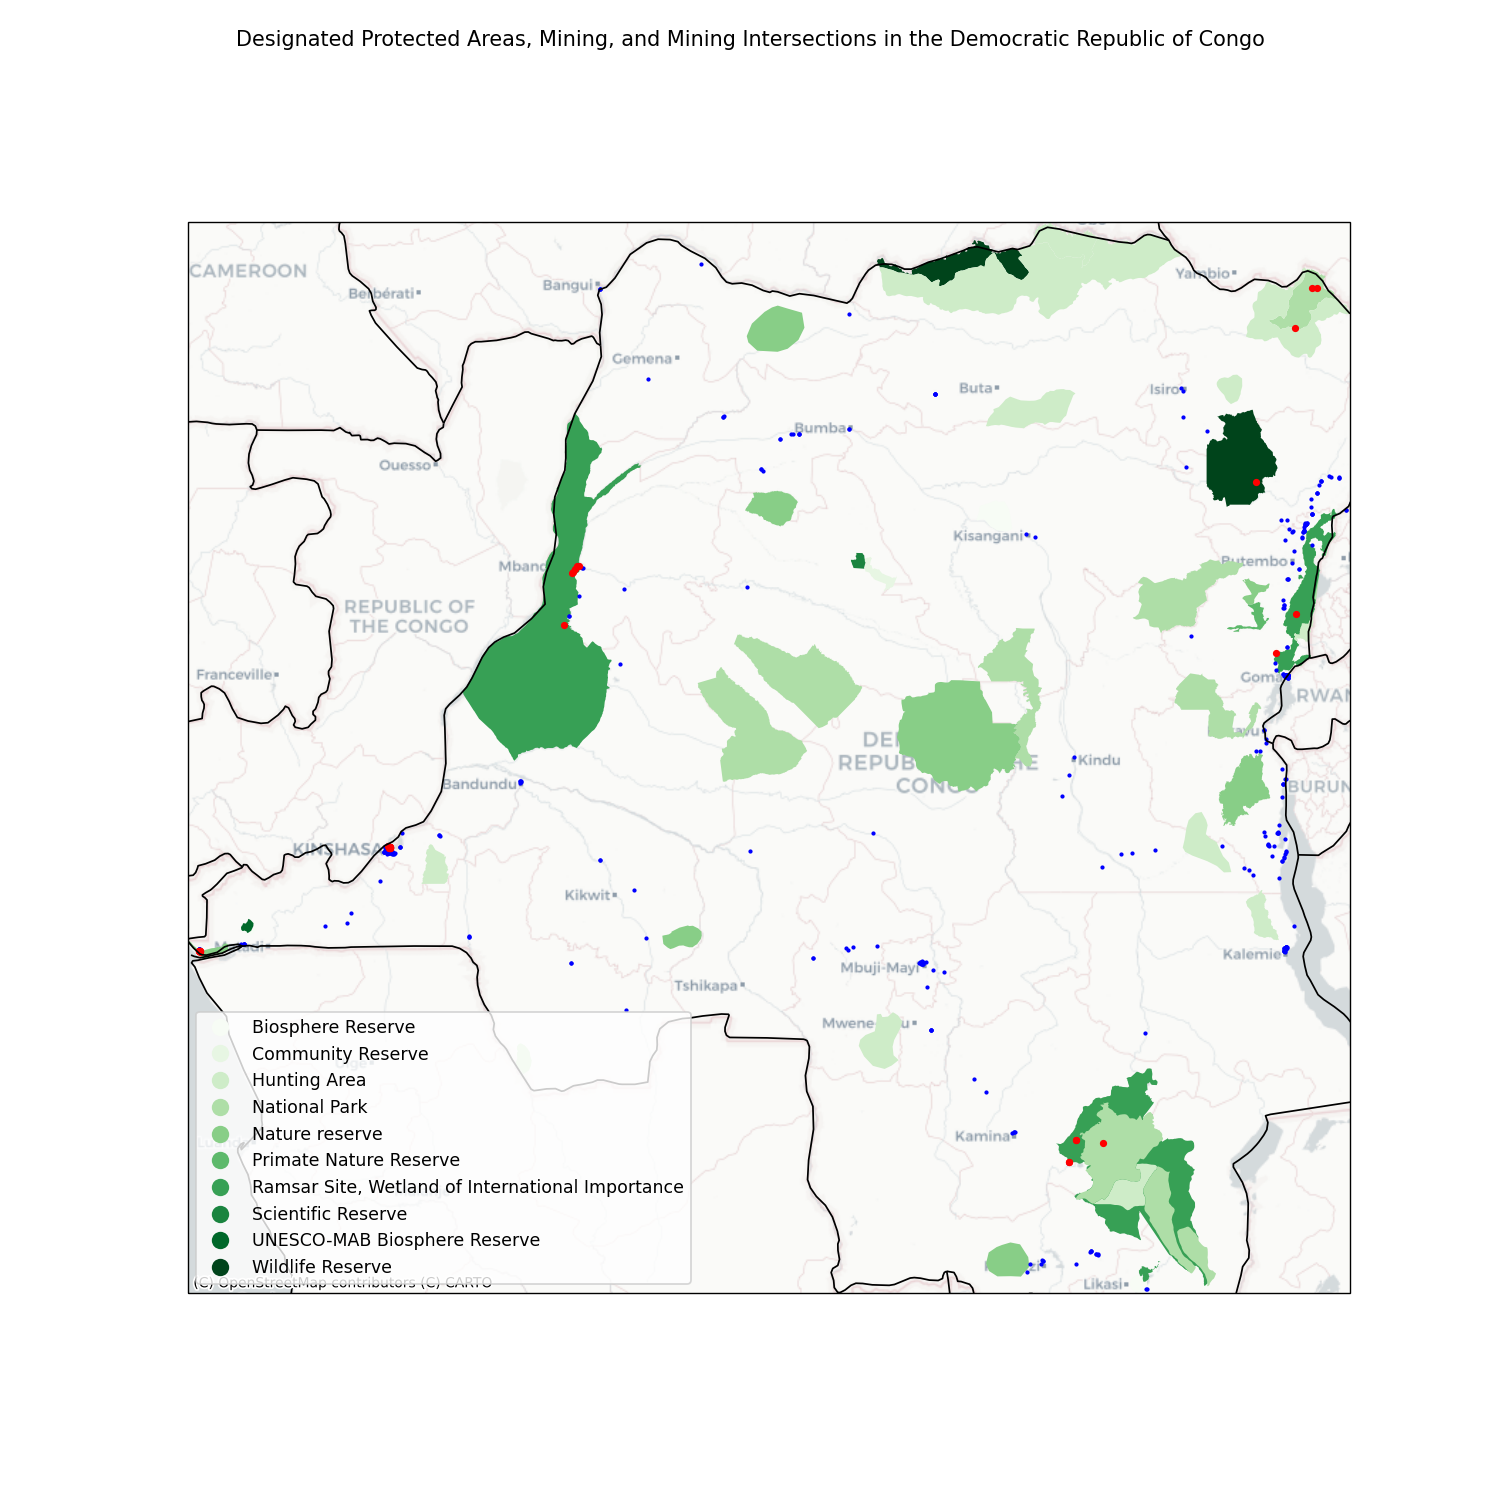

In [16]:
#First product: map with all mines and protected areas, intersecting mines in blue
pa_map, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection=ccrs.Mercator()))

xmin, ymin, xmax, ymax = pa.total_bounds
ax.set_extent([xmin, xmax, ymin, ymax], crs=ccrs.Mercator())

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
pa_h = pa.plot("DESIG_ENG", legend=True, ax=ax, cmap="Greens", label= 'Protected Area')
mines_shp.plot(marker='o', ax=ax, color="blue", markersize=2, legend = True, categorical=True, label = 'Mining Activity')
pa_mine_intersect.plot(marker='o', ax=ax, color="red", markersize=10, legend = True, label = 'Mining Activity Intersecting Protected Areas')


pa_map.suptitle('Designated Protected Areas, Mining, and Mining Intersections in the Democratic Republic of Congo')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.savefig('drc_pas_mines_intersect.png',dpi=300)

In [ ]:
#Count intersections
intersection_cnt = gpd.sjoin(pa, mines_shp).groupby('NAME').size().reset_index()
intersection_cnt.head()

In [ ]:
#Merge and plot, save as CSV
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
pa = pa.merge(intersection_cnt, on='NAME')
pa

pa.to_csv('pa_mine_intersection_cnt.csv', header=True)

In [ ]:
pa_maps = pa.groupby('NAME')

plt.figure()

# Iterate through continents

for i, (name, pa_gdf) in enumerate(pa_maps):
    # create subplot axes in a 3x3 grid
    ax = plt.subplot(3, 3, i + 1) # nrows, ncols, axes position
    # plot the pa on these axes
    pa_gdf.plot(ax=ax,column='NAME', cmap='jet')
    pa_mine_intersect.plot(ax=ax, color="red", markersize=2, marker='o')
    # set the title
    ax.set_title(name, fontsize='7')
    #set the extent
    #pa_bounds = pa_gdf.geometry.bounds
    xmin, ymin, xmax, ymax = pa_gdf.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    #adjustable datalim ensure that the plots have the same axes size
    ax.set_aspect('equal', adjustable='datalim')
    ax.set_axis_off()
    
plt.suptitle('Protected Areas with Mining Activity in the Democratic Republic of Congo')
plt.tight_layout()
plt.show()
